### Required Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cyvcf2 import VCF
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Submission Code 

## Extract and Format Variant Information

In [50]:
vcf_file_path = "data/SNV.somatic.sweetelf.merged.clinical.ranked.vcf.gz"

In [51]:
def parse_csq(fields, csq_str):
    csq = []
    annotation_list = csq_str.split(",")
    for annotation in annotation_list:   
        csq.append(dict(zip(fields, annotation.split("|"))))
        return csq

def extract_csq_keys(parsed_csq, keys):
    annos = []
    values = []
    
    for anno in parsed_csq:
        for item in anno.items():
            if item[0] in keys:
                annos.append(item[0])
                values.append(item[1])
    return dict(zip(annos, values))    

def extract_info_keys(info_field, keys):
    annos = []
    values = []
    
    for key in keys:
        annos.append(key)
        values.append(info_field.get(key, ""))
        
    return dict(zip(annos, values))

def parse_vcf(path_to_vcf):
    vcf = VCF(path_to_vcf)
    csq_fields = vcf.get_header_type("CSQ")["Description"][51:-1].split("|")
    data = []
    for variant in vcf:
        chrom = variant.CHROM
        pos = variant.POS
        ref = variant.REF
        alt = variant.ALT[0] if len(variant.ALT) else ""
        filter_value = variant.FILTER
        
        info = variant.INFO
        #info_keys = ["CSQ", "RankResult", "RankScore", "CLNSIG", "AF", "DP", "GNOMAD_AF"]
        # extract INFO-keys
        info_keys = extract_info_keys(info, keys=["CSQ", "RankResult", "RankScore", "CLNSIG", "AF", "DP", "GNOMAD_AF"]) 
        
        #csq_str = info.get("CSQ", "") 
        af, pp, con, vcqf, lin, clin = [float(x) for x in info_keys.get("RankResult", "0|0|0|0|0|0").split("|")]   
        rank_score = float(info_keys.get("RankScore").split(":")[1])   
        clnsig = info_keys.get("CLNSIG", "") 
        vaf = info_keys.get("AF", "")
        coverage = info_keys.get("DP", "")

        # Parse CSQ 
        csq = parse_csq(csq_fields, info_keys.get("CSQ", ""))
        csq_keys = extract_csq_keys(csq, keys = ["Consequence", "SIFT", "PolyPhen", "gnomAD_AF", "COSMIC", "CLIN_SIG"])


        # Format strings for extracting controls
        chrom_pos = f"{chrom}_{pos}"
        ref_alt = f"{ref}_{alt}"
        
        data.append({
            "VARIANT": f"{chrom_pos}_{ref_alt}",
            "CHROM_POS": chrom_pos,
            "AF": af,
            "PP": pp,
            "CON": con,
            "VCQF": vcqf,
            "LIN": lin,
            "CLIN": clin,
            "CLNSIG": clnsig,
            "RANK_SCORE": rank_score,
            #"parsed_csq": csq,
            #"csq_key": csq_keys,
            #"Consequence": csq_keys.get("Consequence", ""), 
            #"SIFT": csq_keys.get("SIFT", ""), 
            #"PolyPhen": csq_keys.get("PolyPhen", ""), 
            #"gnomAD_AF": csq_keys.get("gnomAD_AF", ""), 
            #"COSMIC": csq_keys.get("COSMIC", ""), 
            #"CLIN_SIG": csq_keys.get("CLIN_SIG", ""),
            #"FILTER": filter_value,
            #"VAF(AF)": vaf,
            #"COVERAGE(DP)": coverage
        })
    return pd.DataFrame(data)

## Group Variants and Mark Controls

In [48]:
GROUPS_WITH_LABELS = {
    "benign": ['Benign',
               'Likely_benign',
               'Benign/Likely_benign',
               'Benign|drug_response',
               'Likely_benign|other',
               'Likely_benign|drug_response|other'],
    "pathogenic": ['Pathogenic',
                   'Pathogenic/Likely_pathogenic',
                   'Pathogenic|other',
                   'Likely_pathogenic',
                   'Likely_pathogenic|association',
                   'Pathogenic/Likely_pathogenic|risk_factor',
                  'Pathogenic|drug_response'],
    "uncertain": ['Conflicting_classifications_of_pathogenicity',
                  'Conflicting_classifications_of_pathogenicity|drug_response|other',
                  'Conflicting_classifications_of_pathogenicity|association',
                  'Uncertain_significance'],
    "other": ['', 'not_provided', 'drug_response']
}

def group_variants(df, from_col="CLNSIG", groups=GROUPS_WITH_LABELS, to_col="GROUP"):
    """ 
    Groups variants by 'groups' based on information in 'from_col'.
    Adjusts RANK_SCORE by subtracting CLIN Score to mitigate bias.
    Args:
    df (pd.DataFrame): data with variants to group
    from_col (str): the column in df to use for grouping (required in df)
    to_col (str): the name of the new column that will contain variant group labels
    Returns:
    df (pd.DataFrame): the df extended with 'to_column' values and 'ADJUSTED_SCORE'. 
    """
    df[from_col] = df[from_col].str.strip()
    
    def classify(clnsig):
        for group, labels in groups.items():
            if clnsig in labels:
                return group
        print(f"Unmatched CLNSIG value: {clnsig}")  # Log unmatched values
        return "other"  # Return original label if no match is found

    # Apply the classification logic to the DataFrame
    df[to_col] = df[from_col].apply(classify)
    
    df["ADJUSTED_SCORE"] = df["RANK_SCORE"] - df["CLIN"]
    
    return df

def mark_controls(df, controls="data/controls_match.tsv"):
    c = pd.read_csv(controls, sep="\t")
    control_set = set(c["chrom_pos"])
    df["IS_CONTROL"] = df["CHROM_POS"].isin(control_set)
    return df

In [58]:
# read VCF file into a pandas Dataframe 
df_hd829 = parse_vcf(vcf_file_path) 
df_clinvar = parse_vcf(clinvar_path)

# Group variants
df_hd829 = group_variants(df_hd829.copy())
df_clinvar = group_variants(df_clinvar.copy())

# Mark controls
df_hd829 = mark_controls(df_hd829)


# Extended Dataset
A subset (ask Mathias) of ClinVar.vcf latest was cleaned from prior annotations before the Balsamic annotation and scoring workflow was applied. 
This VCF contained ~51222 scored variants. 

Because ClinVar contains various annotations not specific to cancer, the dataset was filtered to align with this project aim. 

## Filter SNVs with CLNSIG values "Pathogenic" or "Benign" and Review Status
To extract only variants annotated (CLNSIG) as "Pathogenic" or "Benign" the following command was used. 
    
    grep -E "^#|CLNSIG=.*(Pathogenic|Benign)" input.vcf > filtered_clinvar.vcf
    
^#: Keeps the header lines.
CLNSIG=.*(Pathogenic|Benign): Matches INFO lines where CLNSIG contains "Pathogenic" or "Benign".

In order to get best possible quality variants, the filtered dataset was filtered by Review Status "expert panel" or "practice guideline". To achieve this, the following command was used: 

    grep -E "^#|CLNREVSTAT=.*(expert_panel|practice_guideline)" filtered_clinvar.vcf > high_confidence.vcf

CLNREVSTAT=.*(expert_panel|practice_guideline): Matches variants with high-confidence review statuses.

Finally, the dataset was filtered to only retain SNVs in order to be representative for this project. SNVs (Single Nucleotide Variants) can be identified where the REF and ALT columns are single bases (e.g., A, C, G, T). To filter such rows awk was used: 

    awk 'BEGIN {OFS="\t"} /^#/ {print $0} !/^#/ && length($4) == 1 && length($5) == 1 {print $0}' high_confidence.vcf > snvs_only.vcf

/^#/: Retains header lines.
length($4) == 1 && length($5) == 1: Ensures both REF (column 4) and ALT (column 5) are single bases.

## Verify Output
To verify the generated files by counting the lines in each file:

    wc -l input.vcf filtered_clinvar.vcf high_confidence.vcf snvs_only.vcf

* filtered_clinvar.vcf: Variants with "Pathogenic" or "Benign" CLNSIG values.
* high_confidence.vcf: Subset with high-confidence review statuses.
* snvs_only.vcf: Further filtered for SNVs only.

## Assess Class Distribution 
Determine the number and percentage of benign and pathogenic variants.

In [ ]:
def assess_distribution(df, label_col):
    class_distribution = df[label_col].value_counts()
    class_percentage = df[label_col].value_counts(normalize=True) * 100 # With normalize set to True , returns the relative frequency by dividing all values by the sum of values.
    
    print("Class Distribution:")
    print(class_distribution)
    print("\nClass Percentage:")
    print(class_percentage)

    # Visualize
    # Bar chart
    class_distribution.plot(kind="bar")
    plt.title("Class Distribution")
    plt.ylabel("Number of Variants")
    plt.xlabel("GROUP")
    plt.show()

    # Pie chart
    class_distribution.plot(kind="pie", autopct="%1.1f%%", startangle=90)
    plt.title("Class Percentage")
    plt.ylabel("")
    plt.show()
    

Class Distribution:
GROUP
pathogenic    3230
benign        2203
Name: count, dtype: int64

Class Percentage:
GROUP
pathogenic    59.4515
benign        40.5485
Name: proportion, dtype: float64


## Visualize the Class Balance

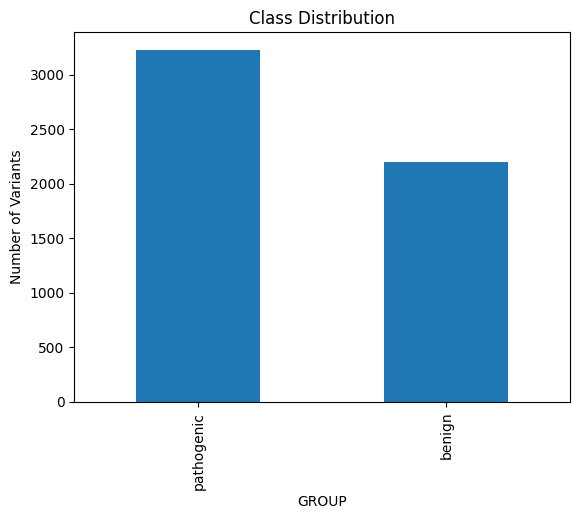

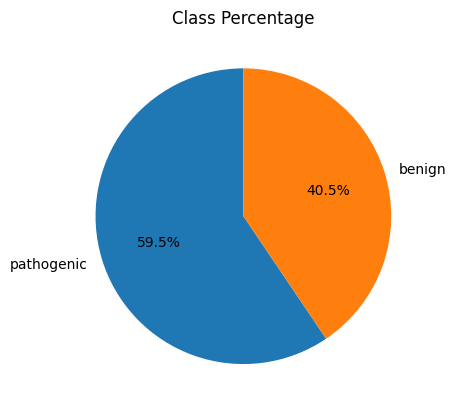

In [77]:
import matplotlib.pyplot as plt



## Statistical Summary
If the labels are numeric (e.g., 0 for benign and 1 for pathogenic), calculate summary statistics.

In [79]:
summary_stats = df_clinvar["GROUP"].describe() 
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
count           5433
unique             2
top       pathogenic
freq            3230
Name: GROUP, dtype: object


## Check for Imbalance
Imbalance is when one class dominates the other. A common threshold is when one class constitutes more than 80% of the data. 

In [80]:
imbalance_threshold = 80
if any(class_percentage > imbalance_threshold):
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

The dataset is balanced.


In [82]:
grouped_data = df_clinvar.groupby("CLNSIG").size()
print(grouped_data)

CLNSIG
Benign                      2203
Pathogenic                  3191
Pathogenic|drug_response      39
dtype: int64


# Analysis

## Scatter Plot With Controls By Group
- Get an overview of the score distribution accross groups
  - each group has unique color
  - controls are higlighted
- Identify potential patterns, such as clusters or outliers
  - Use jitter to avoid overlapping points


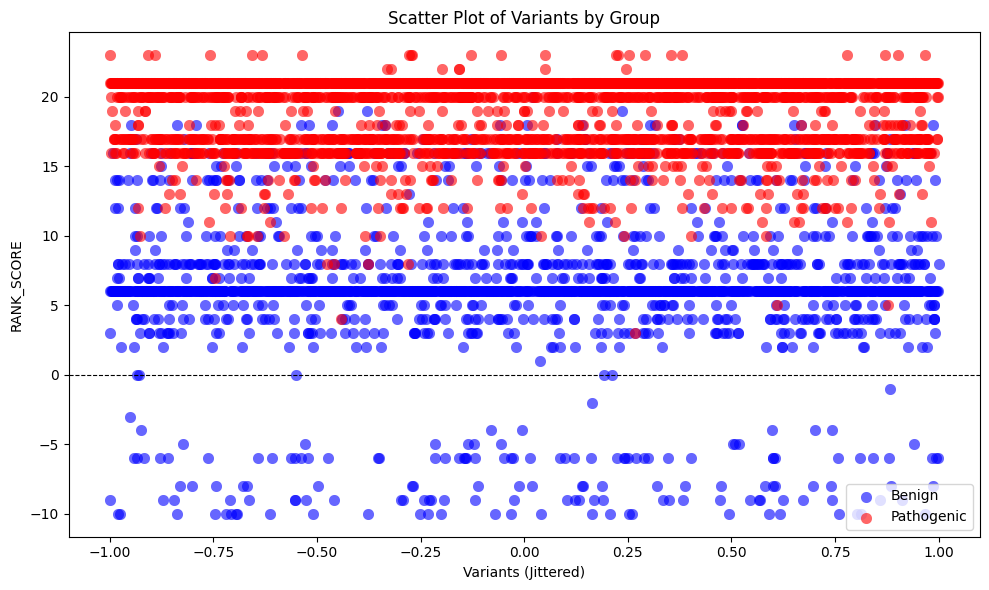

In [73]:
# Scatter Plot Groups
def plot_scatter_with_controls(df, score_col="RANK_SCORE", group_col="GROUP", control_col="IS_CONTROL"):
    """
    Creates a scatter plot with jitter, coloring by group, and highlighting controls.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - score_col (str): Column for the score to plot on the y-axis.
    - group_col (str): Column for the groups to color points.
    - control_col (str): Column indicating control variants (boolean).
    """
    # Generate jitter for x-axis
    jitter = np.random.uniform(-1.0, 1.0, size=len(df))

    # Assign colors for groups
    group_colors = {
        "benign": "blue",
        "pathogenic": "red",
        "other": "gray",
        "uncertain": "orange",
    }

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    for group, color in group_colors.items():
        subset = df[df[group_col] == group]
        plt.scatter(
            x=jitter[subset.index],
            y=subset[score_col],
            s=60,
            label=group.capitalize() if not subset.empty else None,
            color=color,
            alpha=0.6,
            edgecolor="black" if control_col in subset.columns else None,
            linewidth=0.2,
        )
    
    # Highlight controls
    if control_col in df.columns:
        controls = df[df[control_col]]
        plt.scatter(
            x=jitter[controls.index],
            y=controls[score_col],
            facecolors="#9AFF60",
            edgecolors="black",
            label="Control",
            s=120,
        )

    # Plot formatting
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
    plt.xlabel("Variants (Jittered)")
    plt.ylabel(score_col)
    plt.title("Scatter Plot of Variants by Group")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("scatter_by_group.png")
    plt.show()

# Call the function
plot_scatter_with_controls(df_clinvar)

## Reduce Noice and Focus on Benign and Pathogenic Groups
- Retain rows where the GROUP is either Benign or Pathogenic
- Calculate adjusted score (RANK_SCORE - CLIN)
- visualize separatione between Benign and Pathogenic groups by ADJUSTED_SCORE in a violin plot
- visualize ADJUSTED_SCORE distribution in a density plot


### Step 1 & 2: Filter and Adjust Scores
{'Total Rows': 1381, 'Group Counts': {'benign': 1342, 'pathogenic': 39}, 'Adjusted Score Range': (-17.0, 15.0)}


In [999]:
# Step 1: Filter for Benign and Pathogenic groups
filtered_df = df[df['GROUP'].isin(['benign', 'pathogenic'])].copy()

# Step 2: Calculate ADJUSTED_SCORE
#filtered_df['ADJUSTED_SCORE'] = (filtered_df['RANK_SCORE'] - filtered_df['CLIN'])

# Summarize the filtered dataset
filtered_summary = {
    "Total Rows": filtered_df.shape[0],
    "Group Counts": filtered_df['GROUP'].value_counts().to_dict(),
    "Adjusted Score Range": (filtered_df['ADJUSTED_SCORE'].min(), filtered_df['ADJUSTED_SCORE'].max())
}

print(filtered_summary)

{'Total Rows': 1381, 'Group Counts': {'benign': 1342, 'pathogenic': 39}, 'Adjusted Score Range': (-17.0, 15.0)}


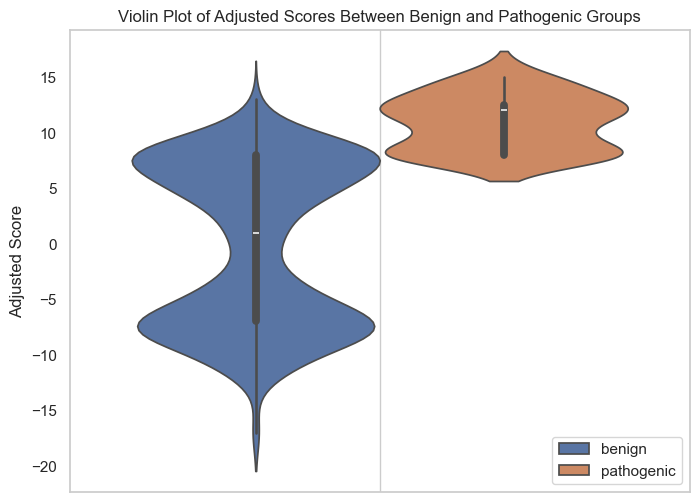

In [1012]:
# Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=filtered_df,
    hue='GROUP',
    y='ADJUSTED_SCORE',
    
)
plt.title("Violin Plot of Adjusted Scores Between Benign and Pathogenic Groups")
plt.ylabel("Adjusted Score")
plt.grid()
plt.legend(loc="lower right")
plt.savefig("violin_adjusted_scores_by_group.png")
plt.show()

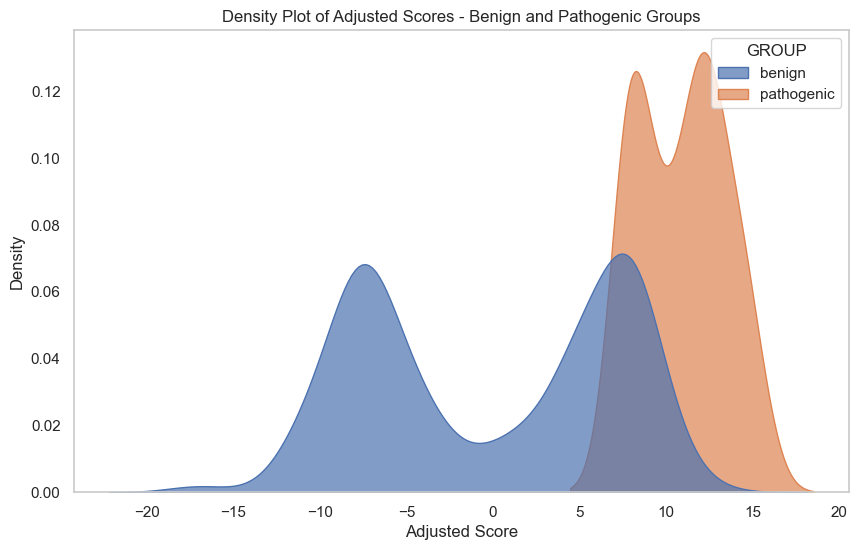

In [1013]:
# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=filtered_df,
    x='ADJUSTED_SCORE',
    hue='GROUP',
    fill=True,
    common_norm=False,
    alpha=0.7
)
plt.title("Density Plot of Adjusted Scores - Benign and Pathogenic Groups")
plt.xlabel("Adjusted Score")
plt.ylabel("Density")
plt.grid()
plt.savefig("density_adjusted_by_group.png")
plt.show()

## Threshold Analysis
- analyze overlaps
- iterate steps for re-weighting

Optimal Threshold (Max F1-Score): 11


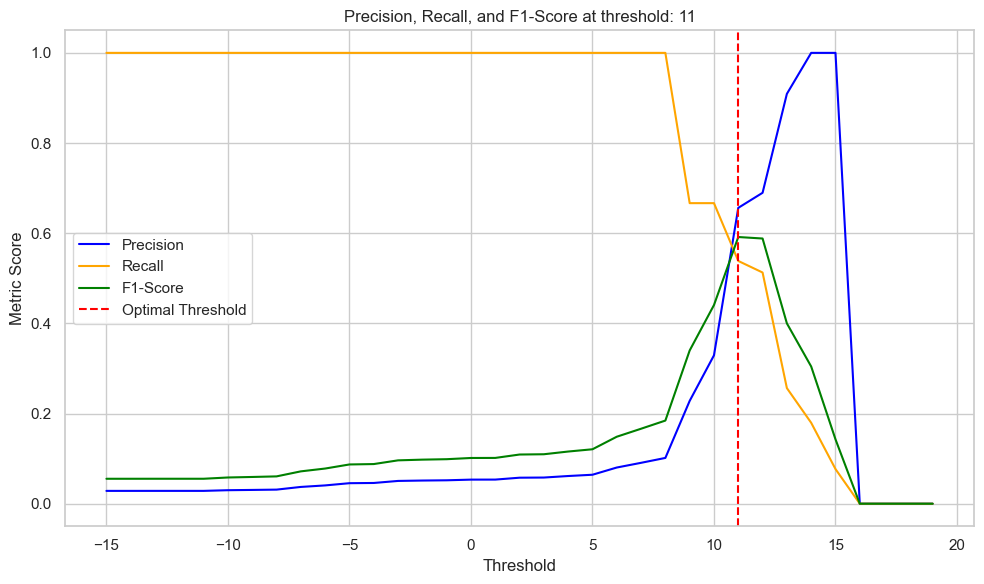

In [1014]:
# Workflow 1: Threshold Analysis

# Step 1: Define a function to calculate metrics for thresholds
def calculate_metrics_by_threshold(scores, labels, thresholds):
    results = []
    for threshold in thresholds:
        y_pred = (scores >= threshold).astype(float)
        precision = precision_score(labels, y_pred, zero_division=0)
        recall = recall_score(labels, y_pred, zero_division=0)
        f1 = f1_score(labels, y_pred, zero_division=0)
        results.append({"threshold": threshold, "precision": precision, "recall": recall, "f1_score": f1})
    return pd.DataFrame(results)

# Step 2: Define a function to visualize the metrics
def visualize_metrics(metrics_df):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df["threshold"], metrics_df["precision"], label="Precision", color="blue")
    plt.plot(metrics_df["threshold"], metrics_df["recall"], label="Recall", color="orange")
    plt.plot(metrics_df["threshold"], metrics_df["f1_score"], label="F1-Score", color="green")
    plt.axvline(metrics_df.loc[metrics_df["f1_score"].idxmax(), "threshold"], color="red", linestyle="--", label="Optimal Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    # Find the threshold with the maximum F1-Score
    optimal_threshold = metrics_df.loc[metrics_df["f1_score"].idxmax(), "threshold"]
    plt.title(f"Precision, Recall, and F1-Score at threshold: {optimal_threshold}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"threshold_analysis_threshold: {optimal_threshold}.png")
    # From the plot, select the threshold that maximizes your chosen metric.

    print(f"Optimal Threshold (Max F1-Score): {optimal_threshold}")
    plt.show()

# Step 3: Run the workflow
# Assuming `df` has the columns "ADJUSTED_SCORE" and "GROUP" with 'benign' and 'pathogenic' labels
filtered_df = filtered_df[filtered_df["GROUP"].isin(["benign", "pathogenic"])]
y_true = (filtered_df["GROUP"] == "pathogenic").astype(int)

thresholds = range(-15, 20)
# Calculate metrics
threshold_metrics = calculate_metrics_by_threshold(filtered_df["ADJUSTED_SCORE"], y_true, thresholds)

# Visualize metrics
visualize_metrics(threshold_metrics)



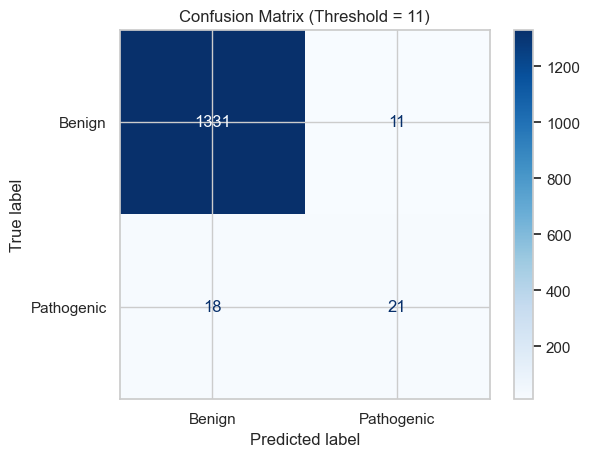

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      1342
  Pathogenic       0.66      0.54      0.59        39

    accuracy                           0.98      1381
   macro avg       0.82      0.77      0.79      1381
weighted avg       0.98      0.98      0.98      1381



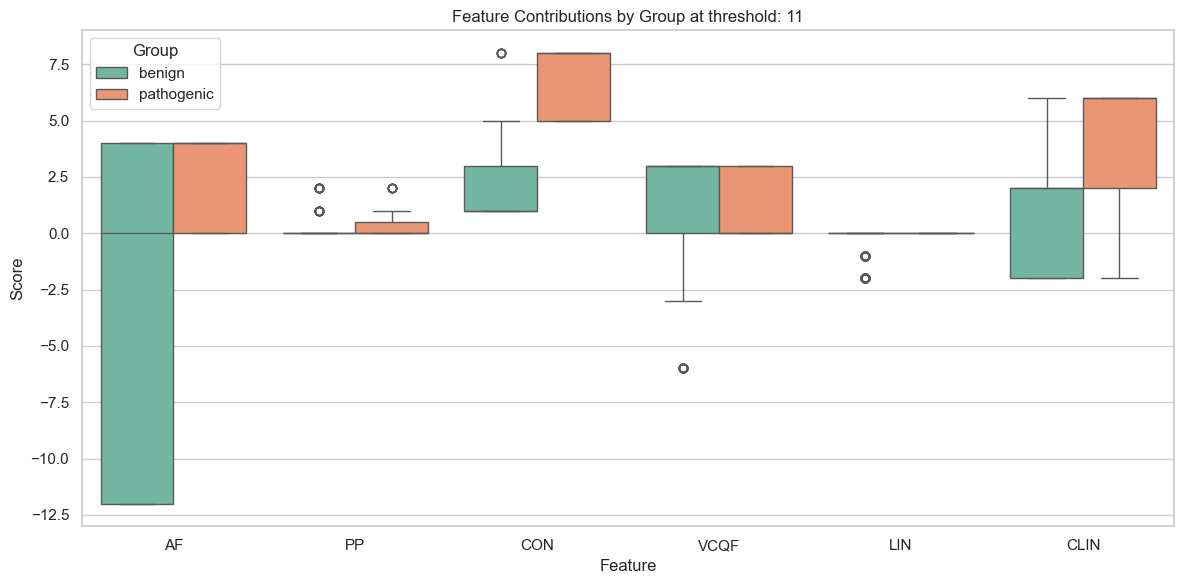

In [1016]:
# Workflow 2: Calculate and Visualize Metrics for Optimal Threshold 


# Function to classify variants based on the optimal threshold
def classify_variants(df, threshold):
    df = df.copy()
    df['y_pred'] = (df['ADJUSTED_SCORE'] >= threshold).astype(int)
    df['y_true'] = df['GROUP'].map({'benign': 0, 'pathogenic': 1})
    return df

# Step 1: Define functions to plot the confusion matrix and feature contributions
def plot_confusion_matrix(df, threshold):
    # Classify variants
    df = classify_variants(df, threshold)
    
    # Extract true and predicted labels
    y_true = df['y_true']
    y_pred = df['y_pred']
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Pathogenic"])
    
    # Plot confusion matrix
    disp.plot(cmap='Blues', values_format='d')
    disp.ax_.set_title(f"Confusion Matrix (Threshold = {threshold})")
    
    # Save as PNG
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.savefig(f"confusion_matrix_threshold_{threshold}.png")
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Pathogenic"]))
    
    return cm

def plot_feature_contributions(melted_df, threshold):
    # Plot feature contributions
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted_df, x="Feature", y="Score", hue="GROUP", palette="Set2")
    plt.title(f"Feature Contributions by Group at threshold: {threshold}")
    plt.xlabel("Feature")
    plt.ylabel("Score")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.savefig(f"feature_contributions_at_threshold_{threshold}.png")
    plt.show()

# Step 2: Apply the optimal threshold
optimal_threshold = threshold_metrics.loc[threshold_metrics["f1_score"].idxmax(), "threshold"]
y_pred = (filtered_df["ADJUSTED_SCORE"] >= optimal_threshold).astype(int)

# Step 3: Plot the confusion matrix
plot_confusion_matrix(filtered_data, optimal_threshold)

# Melt the data for plotting feature contributions
melted_data = filtered_df.melt(
    id_vars=["GROUP"], 
    value_vars=["AF", "PP", "CON", "VCQF", "LIN", "CLIN"], 
    var_name="Feature", 
    value_name="Score"
)
plot_feature_contributions(melted_data, optimal_threshold)

Optimal Threshold (Max F1-Score): 12


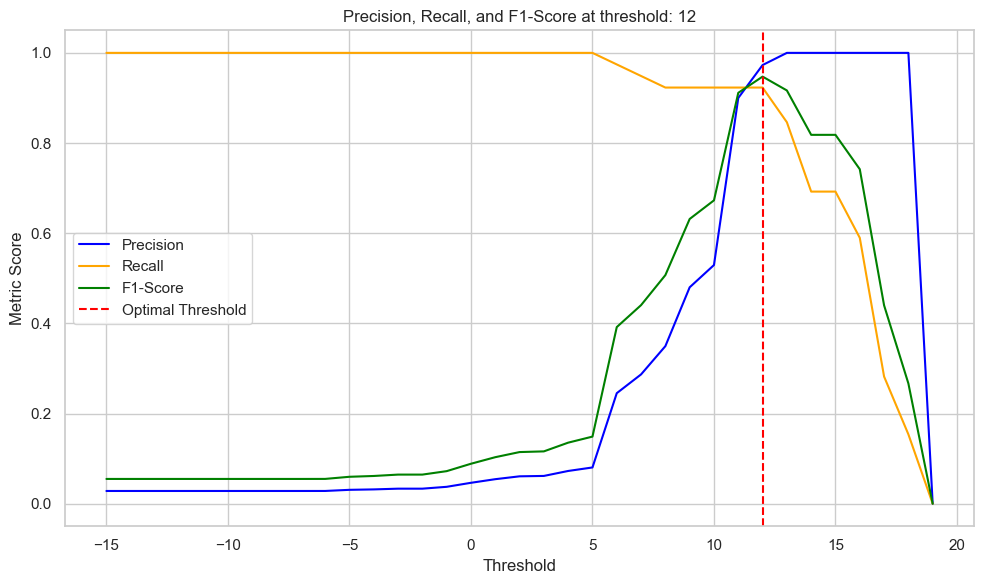

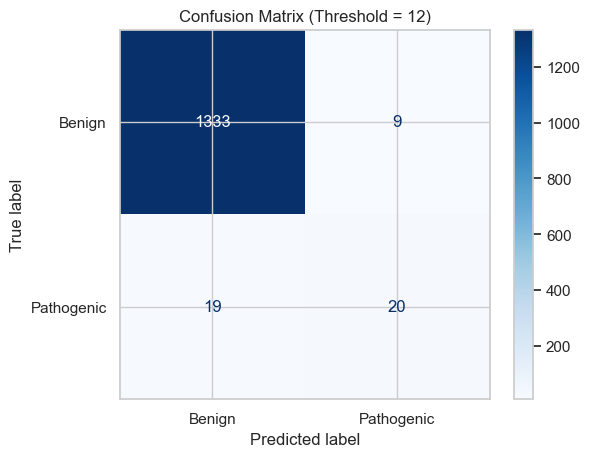

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      1342
  Pathogenic       0.69      0.51      0.59        39

    accuracy                           0.98      1381
   macro avg       0.84      0.75      0.79      1381
weighted avg       0.98      0.98      0.98      1381



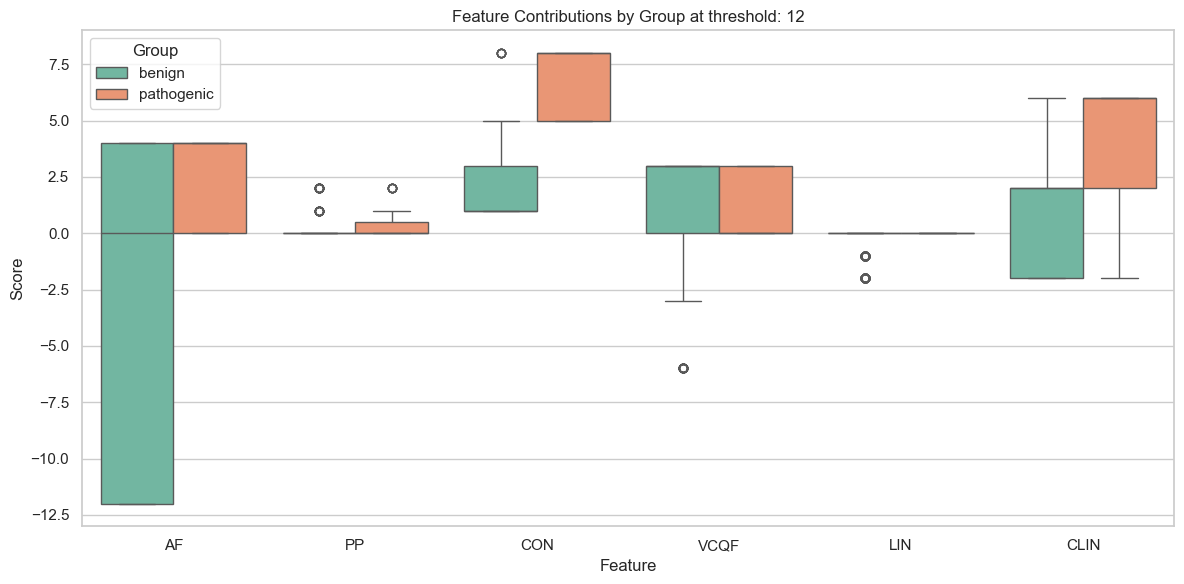

In [1017]:
# Workflow 3: Reweight, Recalculate, and Revisualize 

# Step 1: Define new weights
NEW_WEIGHTS = {
    "AF": 0.4,
    "PP": 1.1,
    "CON": 1.2,
    "VCQF": 0.1,
    "LIN": 0.1,
    "CLIN": 1.2
}

# Step 2: Recalculate rank scores
def recalculate_rank_scores(df, weights):
    df["UPDATED_RANK_SCORE"] = (
        df["AF"] * weights["AF"] +
        df["PP"] * weights["PP"] +
        df["CON"] * weights["CON"] +
        df["VCQF"] * weights["VCQF"] +
        df["LIN"] * weights["LIN"] +
        df["CLIN"] * weights["CLIN"]
    )
    return df

df = recalculate_rank_scores(filtered_df, NEW_WEIGHTS)

melted_data = df.melt(
    id_vars=["GROUP"], 
    value_vars=["AF", "PP", "CON", "VCQF", "LIN", "CLIN"], 
    var_name="Feature", 
    value_name="Score"
)

# Step 3: Repeat Threshold Analysis
threshold_metrics_updated = calculate_metrics_by_threshold(df["UPDATED_RANK_SCORE"], y_true, thresholds)
visualize_metrics(threshold_metrics_updated)

# Step 4: Plot Confusion Matrix for Updated Scores
optimal_threshold_updated = threshold_metrics_updated.loc[threshold_metrics_updated["f1_score"].idxmax(), "threshold"]
y_pred_updated = (df["UPDATED_RANK_SCORE"] >= optimal_threshold_updated).astype(int)
plot_confusion_matrix(df, optimal_threshold_updated)
plot_feature_contributions(melted_data, optimal_threshold_updated)

In [ ]:
## Proposed Refinement Steps

### Analyze Feature Contributions
	•	Decompose the RANK_SCORE into its contributing categories (AF, PP, CON, VCQF, LIN, CLIN) for the benign and pathogenic groups.
	•	Visualize the contributions for each group to identify potential feature-level discrepancies. For example:
	•	Boxplots or violin plots for each feature by group.
	•	Heatmaps to show feature interactions.
	•	Goal: Pinpoint features that disproportionately contribute to misclassifications.

### Reweight Feature Contributions
	•	Adjust the weights of the contributing categories in RANK_SCORE based on the analysis:
	•	Reduce weights for features contributing noise (e.g., overly high scores for benign variants in the pathogenic range).
	•	Increase weights for features highly discriminative of pathogenic variants (e.g., CLIN).
	•	Recalculate RANK_SCORE and visualize adjusted contributions.

### Test New Thresholds
	•	Perform a threshold analysis on the recalibrated RANK_SCORE:
	•	Generate precision, recall, and F1-score curves.
	•	Identify the new optimal threshold.
	•	Compare the confusion matrix with the previous one to evaluate improvement.

### Incorporate Feature Quality Checks
	•	Examine the quality of individual features (e.g., missing or erroneous annotations in SIFT, PolyPhen, or gnomAD_AF).
	•	Filter out low-quality annotations or rows with missing data in critical features.
	•	Recompute RANK_SCORE and reanalyze.

### Validate the Model
	•	Split the annotated dataset into a training set (e.g., 70%) and testing set (e.g., 30%).
	•	Train the model on the training set to optimize feature weights.
	•	Evaluate the model on the testing set using metrics such as AUC, precision, recall, and F1-score.

### Visualize Results
	•	For each refinement iteration:
	•	Plot feature contributions for both groups.
	•	Update confusion matrix, precision-recall curves, and ROC curve.
	•	Overlay before-and-after visualizations to demonstrate improvements.

## Adjusting Feature Weights 
The goal of this step is to reweight the contributions of the scoring model’s features to improve the separation between benign and pathogenic variants.

### Analyze Current Contributions:
Based on the boxplot, we know that AF, CON, and CLIN are the dominant features.
Features like VCQF, PP, and LIN show less impact and could either be down-weighted or excluded.

### Define New Weights:
	•	Assign higher weights to AF, CON, and CLIN.
	•	Reduce or set the weight of LIN to zero.
	•	Adjust weights for PP and VCQF based on their overlaps and low discriminative power.

### Recalculate Adjusted Scores:
	•	Update the adjusted score formula as follows:

\text{Adjusted Score} = w_{\text{AF}} \cdot \text{AF} + w_{\text{PP}} \cdot \text{PP} + w_{\text{CON}} \cdot \text{CON} + w_{\text{VCQF}} \cdot \text{VCQF} + w_{\text{LIN}} \cdot \text{LIN} + w_{\text{CLIN}} \cdot \text{CLIN}

	•	Implement the weights as a dictionary for flexibility.
### Reevaluate Metrics:
	•	Visualize the updated feature contributions.
	•	Rerun threshold analysis to find the optimal threshold.
	•	Evaluate the confusion matrix to quantify the improvement.

In [ ]:
# Implementation to handle the low-scoring controls

# 1. Adjust Handling of `CLIN` for Controls
def adjust_clin_for_controls(df):
    """
    Neutralize negative `CLIN` contributions for controls with `Uncertain_significance`.
    """
    df.loc[(df["IS_CONTROL"]) & (df["CLNSIG"] == "Uncertain_significance"), "CLIN"] = 0
    print("Adjusted CLIN values for controls with Uncertain_significance.")
    return df

# 2. Reweight Scoring Formula
def reweight_scoring_formula(df, weights):
    """
    Reweight the scoring formula and recalculate the RANK_SCORE.
    """
    df["REWEIGHTED_RANK_SCORE"] = (
        df["AF"] * weights["AF"] +
        df["PP"] * weights["PP"] +
        df["CON"] * weights["CON"] +
        df["VCQF"] * weights["VCQF"] +
        df["LIN"] * weights["LIN"] +
        df["CLIN"] * weights["CLIN"]
    )
    print("Recalculated RANK_SCORE using new weights.")
    return df

# 3. Update Grouping for Controls
def update_control_grouping(df):
    """
    Reassign the group for controls with `Uncertain_significance` to `control_uncertain`.
    """
    df.loc[(df["IS_CONTROL"]) & (df["GROUP"] == "other"), "GROUP"] = "control_uncertain"
    print("Updated GROUP for controls with Uncertain_significance.")
    return df

# 4. Verify Changes for Specific Controls
def verify_control_updates(df, variant_id):
    """
    Print updated details for a specific control variant.
    """
    control_data = df.loc[df["VARIANT"] == variant_id, ["RANK_SCORE", "NO_CLIN_RANK_SCORE", "CLIN", "GROUP"]]
    print(f"Updated details for variant {variant_id}:")
    print(control_data)

# Example Usage
def main_handle_low_scoring_controls(df):
    # Step 1: Adjust CLIN values for controls
    df = adjust_clin_for_controls(df)

    # Step 2: Reweight scoring formula
    weights = {"AF": 1.0, "PP": 1.0, "CON": 1.5, "VCQF": 1.0, "LIN": 1.0, "CLIN": 0.5}
    df = reweight_scoring_formula(df, weights)

    # Step 3: Update control grouping
    df = update_control_grouping(df)

    # Step 4: Verify changes for the low-scoring control
    verify_control_updates(df, variant_id="21_36206711_C_T")

    return df

# Uncomment and run when `df` is defined
# df = main_handle_low_scoring_controls(df)

# Recommended adjustments based on feature overlaps 
# 1. Adjust CLIN to Avoid Negative Penalties
def neutralize_negative_clin(df):
    """
    Set negative CLIN values to 0 to avoid penalizing controls.
    """
    df["CLIN"] = df["CLIN"].apply(lambda x: 0 if x < 0 else x)
    print("Negative CLIN values have been neutralized.")
    return df

# 2. Reweight Features in the Scoring Formula
def reweight_features(df, weights):
    """
    Apply new weights to feature components and recalculate RANK_SCORE.
    """
    df["REWEIGHTED_RANK_SCORE"] = (
        df["AF"] * weights["AF"] +
        df["PP"] * weights["PP"] +
        df["CON"] * weights["CON"] +
        df["VCQF"] * weights["VCQF"] +
        df["LIN"] * weights["LIN"] +
        df["CLIN"] * weights["CLIN"]
    )
    print("Recalculated RANK_SCORE with updated weights.")
    return df

# 3. Reevaluate Overlap Region
def reevaluate_overlap_region(df, lower_threshold=5, upper_threshold=15):
    """
    Analyze and print statistics for the overlap region after reweighting.
    """
    overlap_controls = df[(df["IS_CONTROL"]) & (df["REWEIGHTED_RANK_SCORE"] > lower_threshold) & (df["REWEIGHTED_RANK_SCORE"] < upper_threshold)]
    print(f"Number of controls in overlap region ({lower_threshold} < REWEIGHTED_RANK_SCORE < {upper_threshold}): {len(overlap_controls)}")
    print("\nDescriptive statistics for feature components in the overlap region:")
    print(overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN", "REWEIGHTED_RANK_SCORE"]].describe())
    return overlap_controls

# 4. Visualize Updated Contributions
def visualize_updated_contributions(overlap_controls):
    """
    Plot boxplot of feature contributions for the overlap region after reweighting.
    """
    overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].boxplot(figsize=(10, 6))
    plt.title("Feature Components in Overlap Region After Reweighting")
    plt.ylabel("Scores")
    plt.xticks(rotation=45)
    plt.savefig("updated_contributions.png")
    plt.show()

# Example Usage
def main_adjust_and_evaluate(df):
    # Step 1: Neutralize negative CLIN values
    df = neutralize_negative_clin(df)

    # Step 2: Reweight features
    weights = {"AF": 1.5, "PP": 1.2, "CON": 1.0, "VCQF": 1.0, "LIN": 1.0, "CLIN": 0.5}
    df = reweight_features(df, weights)

    # Step 3: Reevaluate the overlap region
    overlap_controls = reevaluate_overlap_region(df)

    # Step 4: Visualize updated contributions
    visualize_updated_contributions(overlap_controls)

    return df, overlap_controls

# Uncomment and run when `df` is defined
# df, updated_overlap_controls = main_adjust_and_evaluate(df)

# 1. Fine-Tune Feature Weights
def fine_tune_weights(df):
    """
    Apply fine-tuned weights to the scoring formula for further improvement.
    """
    fine_tuned_weights = {"AF": 2.0, "PP": 1.5, "CON": 0.8, "VCQF": 1.2, "LIN": 1.0, "CLIN": 0.6}
    df["FINE_TUNED_RANK_SCORE"] = (
        df["AF"] * fine_tuned_weights["AF"] +
        df["PP"] * fine_tuned_weights["PP"] +
        df["CON"] * fine_tuned_weights["CON"] +
        df["VCQF"] * fine_tuned_weights["VCQF"] +
        df["LIN"] * fine_tuned_weights["LIN"] +
        df["CLIN"] * fine_tuned_weights["CLIN"]
    )
    print("Applied fine-tuned weights and recalculated FINE_TUNED_RANK_SCORE.")
    return df